# <center> Improving Classification and Object Detection </center>
# <center> using CutMix Augmentation</center>

[Supplementary to my medium article: https://medium.com/@ZenFeather/cutmix-augmentation-in-python-bf099a97afac]

The paper CutMix: Regularization Strategy to Train Strong Classifiers with Localizable Features published in ICCV 2019 proposed the CutMix augmentation strategy to improve deep learning-based classification and localization tasks.

In this augmentation technique, patches are cut and pasted among training images where interestingly the ground truth labels are also mixed proportionally to the area of the patches. By making efficient use of training pixels and retaining the regularization effect of regional dropout, CutMix consistently outperformed the state-of-the-art augmentation strategies on CIFAR and ImageNet classification tasks, as well as on the ImageNet weakly-supervised localization task.

The paper also shows that CutMix improves the model robustness against input corruptions and its out-of-distribution detection performances.

In the following table, we can see the performance boost obtained by adopting CutMix augmentation.

![image.png](attachment:image.png)

Let's start.

## Loading Data

To show the result of CutMix augmentation we will use a set of images containing images of wheat field showing wheat heads. These images are takes from Kaggle's Glbal Wheat Detection competition dataset.

In [ ]:
from google.colab import drive

drive.mount("/content/drive")
%cd '/content/drive/MyDrive/task4_materialType/'

Mounted at /content/drive
/content/drive/MyDrive/task4_materialType


## Generating a Batch of Data

Now, we will create a set or "batch" of 4 images. Let's assume that this batch is a minibacth generated by a dataloader that loads minibatches during the training of the deep neural network model. In general, the bacth loaded by a dataloader also includes a batch of image labels if we are solving a classification problem. We will randomly assign a label to each image from from the set of {0,1,2}. We will further one-hot encode(https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html) these labels to {[1,0,0], [0,1,0], [0,0,1]}. Please follow this((https://stanford.edu/~shervine/blog/pytorch-how-to-generate-data-parallel)) to learn more about dataloaders in PyTorch.

Image labels:
[[0 1 0]
 [0 0 1]
 [0 1 0]
 [0 1 0]]



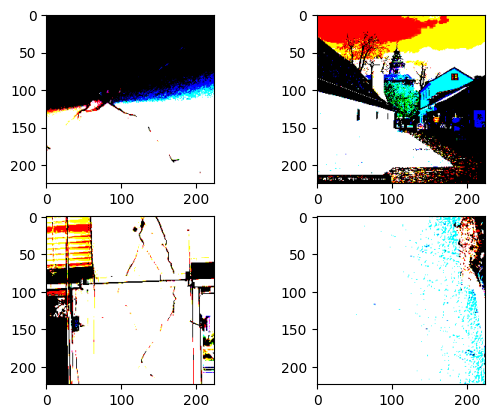

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from skimage import io
import cv2

# Load the npy file
data = np.load("./DDD/data/task4_X_train.npy")

# Assuming data has shape (num_images, height, width, channels)
num_images = min(10, data.shape[0])  # Limit the number of images to 10

# Create a list to store the images
image_list = []

# Loop through the loaded data and append each image to the list
for i in range(num_images):
    image = data[i]
    image_list.append(image)

# Now, image_list contains all the images from the npy file as numpy arrays

# Create batch of 4 images
image_batch = []
image_batch_labels = []

n_images = 4

for i in range(n_images):
    image = image_list[i]
    image_batch.append(image)

    label_temp = list(np.floor(np.random.rand(1)*2.99).astype(int))[0]
    if label_temp == 0:
        label = [1, 0, 0]
    elif label_temp == 1:
        label = [0, 1, 0]
    else:  # label_temp == 2
        label = [0, 0, 1]

    image_batch_labels.append(label)

# Convert image_batch to numpy array
image_batch = np.array(image_batch)
# Convert image_batch_labels to numpy array
image_batch_labels = np.array(image_batch_labels)

# Print labels
print(f"Image labels:\n{image_batch_labels}\n")

# Show images
for i in range(2):
    for j in range(2):
        plt.subplot(2, 2, 2*i+j+1)
        plt.imshow(image_batch[2*i+j])
plt.show()


## Generating Random Bounding Box

Here is a function to generate a random bounding box in an image:

In [ ]:
def rand_bbox(size, lamb):
    """ Generate random bounding box
    Args:
        - size: [width, breadth] of the bounding box
        - lamb: (lambda) cut ratio parameter
    Returns:
        - Bounding box
    """
    W = size[0]
    H = size[1]
    cut_rat = np.sqrt(1. - lamb)
    cut_w = np.int(W * cut_rat)
    cut_h = np.int(H * cut_rat)

    # uniform
    cx = np.random.randint(W)
    cy = np.random.randint(H)

    bbx1 = np.clip(cx - cut_w // 2, 0, W)
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = np.clip(cx + cut_w // 2, 0, W)
    bby2 = np.clip(cy + cut_h // 2, 0, H)

    return bbx1, bby1, bbx2, bby2

Now, let's test the function by generating a random bounding box and crop an image using that bounding box.

<ipython-input-5-01aa337c2866>:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  cut_w = np.int(W * cut_rat)
<ipython-input-5-01aa337c2866>:13: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more det

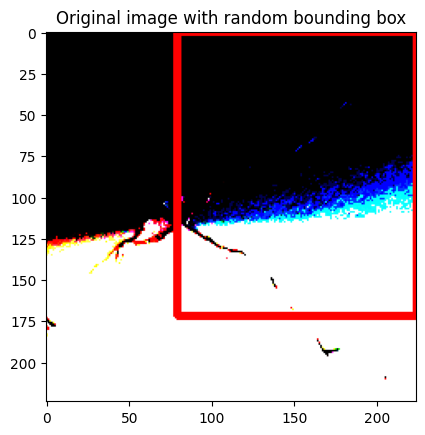

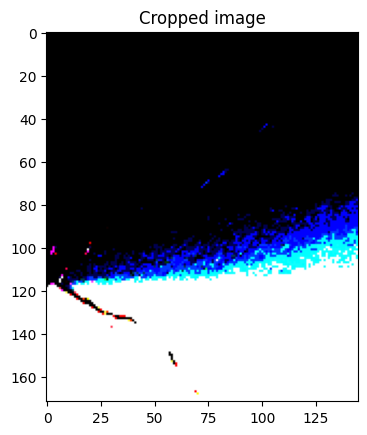

In [ ]:
# Read an image
image = image_list[0]

# Crop a random bounding box
lamb = 0.3
size = image.shape
bbox = rand_bbox(size, lamb)  # You need to have the rand_bbox function defined

# Draw bounding box on the image
im = image.copy()
x1 = bbox[0]
y1 = bbox[1]
x2 = bbox[2]
y2 = bbox[3]
cv2.rectangle(im, (x1, y1), (x2, y2), (255, 0, 0), 3)
plt.imshow(im)
plt.title('Original image with random bounding box')
plt.show()

# Show cropped image
plt.imshow(image[y1:y2, x1:x2])
plt.title('Cropped image')
plt.show()


## A CutMix Image Generation

In CutMix algorithm, for each image of batch a random region (in our case, a random bounding box region) is replaced with a patch from another training image.
- The parameter ```lambda``` that determines the size of the bounding box is stochastically sampled from a Beta distribution(https://en.wikipedia.org/wiki/Beta_distribution).
- The label of each resultant augmented image is estimated as a weighted sum of the original label and the label of the image from which the modified patch is borrowed, where weights are ```lambda``` and ```(1-lambda)``` respectively.

<ipython-input-5-01aa337c2866>:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  cut_w = np.int(W * cut_rat)
<ipython-input-5-01aa337c2866>:13: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more det

Original Images


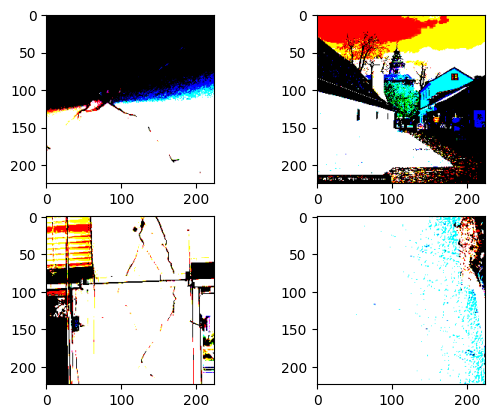

CutMix Images


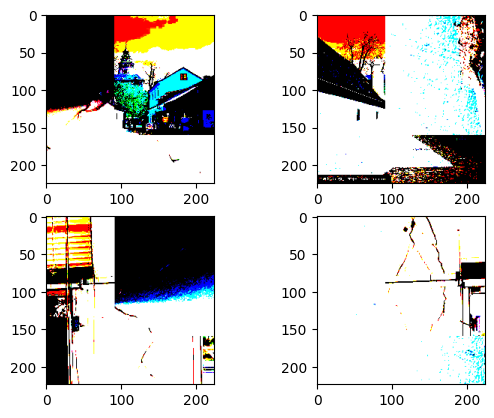

Original labels:
[[0 1 0]
 [0 0 1]
 [0 1 0]
 [0 1 0]]
Updated labels
[[0.         0.57589286 0.42410714]
 [0.         0.42410714 0.57589286]
 [0.         1.         0.        ]
 [0.         1.         0.        ]]


In [ ]:
def generate_cutmix_image(image_batch, image_batch_labels, beta):
    """ Generate a CutMix augmented image from a batch
    Args:
        - image_batch: a batch of input images
        - image_batch_labels: labels corresponding to the image batch
        - beta: a parameter of Beta distribution.
    Returns:
        - CutMix image batch, updated labels
    """
    # generate mixed sample
    lam = np.random.beta(beta, beta)
    rand_index = np.random.permutation(len(image_batch))
    target_a = image_batch_labels
    target_b = image_batch_labels[rand_index]
    bbx1, bby1, bbx2, bby2 = rand_bbox(image_batch[0].shape, lam)
    image_batch_updated = image_batch.copy()
    image_batch_updated[:, bbx1:bbx2, bby1:bby2, :] = image_batch[rand_index, bbx1:bbx2, bby1:bby2, :]

    # adjust lambda to exactly match pixel ratio
    lam = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (image_batch.shape[1] * image_batch.shape[2]))
    label = target_a * lam + target_b * (1. - lam)

    return image_batch_updated, label


# Generate CutMix image
# Let's use the first image of the batch as the input image to be augmented
input_image = image_batch[0]
image_batch_updated, image_batch_labels_updated = generate_cutmix_image(image_batch, image_batch_labels, 1.0)

# Show original images
print("Original Images")
for i in range(2):
    for j in range(2):
        plt.subplot(2,2,2*i+j+1)
        plt.imshow(image_batch[2*i+j])
plt.show()


# Show CutMix images
print("CutMix Images")
for i in range(2):
    for j in range(2):
        plt.subplot(2,2,2*i+j+1)
        plt.imshow(image_batch_updated[2*i+j])
plt.show()

# Print labels
print('Original labels:')
print(image_batch_labels)
print('Updated labels')
print(image_batch_labels_updated)

Now, you can use CutMix augmentation in training you deep neural network model. For more details please follow the references. If you have any questions, please put them in the comment section.

## References:
- https://arxiv.org/pdf/1905.04899.pdf
- https://github.com/clovaai/CutMix-PyTorch